# Presets

## Packages

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import copy
#import difflib
import string_grouper

import unicodedata
from difflib import SequenceMatcher
from heapq import nlargest as _nlargest



pd.options.display.max_rows = 10

## Functions

In [2]:
def flatten(list_of_lists):
    import collections
    
    for sublist in list_of_lists:
        if isinstance(sublist, collections.Iterable) and not isinstance(sublist, (str, bytes)):
            yield from flatten(sublist)
        else:
            yield sublist
            
            
def strf_date_if_not_na(x, strftime='%Y-%m'):
    if pd.isna(x):
        return np.nan
    else:
        return x.strftime('%Y-%m')

In [3]:
def get_close_matches_indexes(word, possibilities, n=10**10, cutoff=0.6):
    """
    Use SequenceMatcher to return a list of the indexes of the best 
    "good enough" matches. word is a sequence for which close matches 
    are desired (typically a string).
    possibilities is a list of sequences against which to match word
    (typically a list of strings).
    Optional arg n (default is large) is the maximum number of close matches to
    return.  n must be > 0.
    Optional arg cutoff (default 0.6) is a float in [0, 1].  Possibilities
    that don't score at least that similar to word are ignored.
    
    Source: https://stackoverflow.com/questions/50861237/is-there-an-alternative-to-difflib-get-close-matches-that-returns-indexes-l
    """

    if not n >  0:
        raise ValueError("n must be > 0: %r" % (n,))
    if not 0.0 <= cutoff <= 1.0:
        raise ValueError("cutoff must be in [0.0, 1.0]: %r" % (cutoff,))
    result = []
    s = SequenceMatcher()
    s.set_seq2(word)
    for idx, x in enumerate(possibilities):
        s.set_seq1(x)
        if s.real_quick_ratio() >= cutoff and \
           s.quick_ratio() >= cutoff and \
           s.ratio() >= cutoff:
            result.append((s.ratio(), idx))

    # Move the best scorers to head of list
    result = _nlargest(n, result)

    # Strip scores for the best n matches
    return [x for score, x in result]

In [ ]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

In [62]:
def map_values(theArray, dictionary, verbose=False, increment=0.1):
    """
    Given an array, map new values according to a dictionary.
    """
    newArray = copy.deepcopy(theArray)
    dict_len = len(dictionary); checkpoint = 0; counter = 0
    for k, v in dictionary.items():
        newArray[theArray==k] = v
        
        if verbose:
            counter += 1; progress = counter / len(dictionary)
            if progress > checkpoint:
                checkpoint += increment
                print('Progress: ' + str(round(progress * 100, 1)) + '%')
    return newArray

## Key values

In [4]:
data_date = datetime.datetime(2020, 4, 11)
disease_startdate = datetime.datetime(2019, 11, 1)

# Subsetting and Pre-Organization

Find only unique articles (disambiguated by CORD-19 as shown by cord_uid).

In [5]:
metadata = pd.read_csv('big-data/metadata_20-04-10.csv')
print('Number of CORD-19 rows: ' + str(len(metadata)))
metadata = metadata.drop_duplicates(subset=['cord_uid'], keep='first') # drop the very few duplicates
print('Number of CORD-19 rows: ' + str(len(metadata)))

Number of CORD-19 rows: 51078
Number of CORD-19 rows: 51045


Find articles relevant to coronaviruses by whether they mention a coronavirus in the abstract.

In [6]:
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)
print('Number of CORD-19 abstracts: ' + str(len(metadata)))
metadata = metadata[metadata['abstract'].str.lower().str.contains(
 "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome|sars-cov-2") | 
     metadata['abstract'].str.contains("MERS")
     ]
metadata = metadata.reset_index(drop=True)
print('Number of relevant CORD-19 rows: ' + str(len(metadata)))

Number of CORD-19 abstracts: 42331
Number of relevant CORD-19 rows: 11000


In [7]:
metadata['covid_or_not'] = metadata['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2')
print('Number of COVID-19 abstracts: ' + str(sum(metadata['covid_or_not'])))

Number of COVID-19 abstracts: 2481


# Author Analytics

## Identifying unique authors

Find separate authors in each article, and store that information.

In [8]:
metadata['authors'] = metadata['authors'].astype(str)
metadata['authors_split'] = metadata['authors'].apply(lambda x: x.split('; ')).tolist()

In [9]:
t = time.time()

article_authors = metadata[['cord_uid', 'authors_split']]
article_authors = article_authors.set_index(['cord_uid'])['authors_split'].apply(pd.Series)\
                                         .stack()\
                                         .reset_index(level=1, drop=True)
article_authors = article_authors.reset_index()
article_authors.columns = ['cord_uid', 'authors']

print(time.time() - t)
article_authors

20.227184772491455


,cord_uid,authors
0,fy4w7xz8,"Lin, Marie"
1,fy4w7xz8,"Tseng, Hsiang-Kuang"
2,fy4w7xz8,"Trejaut, Jean A"
3,fy4w7xz8,"Lee, Hui-Lin"
4,fy4w7xz8,"Loo, Jun-Hun"
...,...,...
77841,32bxx94u,"Lee, Changhee"
77842,4xhcamks,"Valkó, Anna"
77843,4xhcamks,"Bálint, Ádám"
77844,4xhcamks,"Bozsa, Ágnes"


### Author Disambiguation

Process author names in numerous ways, related to character case, last name/first name format, punctuation, character accents, etc.

In [55]:
def status_update(column, details=''):
    print(str(len(np.unique(column))) + ' unique author names ' + details + '.')

# Lower case, firstname-lastname format, remove punctuation
unique_authors = pd.DataFrame(np.unique(article_authors['authors']), columns=['author'])
status_update(unique_authors['author'], details='')

unique_authors['lower_author'] = unique_authors['author'].str.lower()
status_update(unique_authors['lower_author'], details='(lower case)')

unique_authors['comma_count'] = unique_authors['author'].str.count(',')
unique_authors['processed_author'] = unique_authors['lower_author'].str.split(', ')
unique_authors['processed_author'] = unique_authors['processed_author'].apply(
    lambda x: x[1] + ' ' + x[0] if len(x) > 1 else x[0])
status_update(unique_authors['processed_author'], details='(punctuation)')

unique_authors['processed_author'] = unique_authors['processed_author'].str.replace('[^\w\s]','')
status_update(unique_authors['processed_author'], details='(first/surname ordering)')

# Here, in rare cases, characters are deleted outright; I believe, however, this creates
# more consistencies than inconsistencies
unique_authors['processed_author'] = unique_authors['processed_author'].str.normalize('NFKD')\
        .str.encode('ascii', errors='ignore')\
        .str.decode('utf-8') 
status_update(unique_authors['processed_author'], details='(accented characters)')


# Count special cases.
print('Special cases: there are ' + str(sum(unique_authors['comma_count'] > 1)) + ' author names with more than 1 comma.')
print('There are ' + str(sum(unique_authors['comma_count'] == 0)) + ' author names with no comma.')

unique_authors = unique_authors[['author', 'processed_author']]

# Delete excess spaces
length_sum = 0; counter = 0
while length_sum != np.sum(unique_authors['processed_author'].str.len()):
    length_sum = np.sum(unique_authors['processed_author'].str.len())
    unique_authors['processed_author'] = unique_authors['processed_author'].str.lstrip()
    unique_authors['processed_author'] = unique_authors['processed_author'].str.rstrip()
    unique_authors['processed_author'] = unique_authors['processed_author'].str.replace("  ", " ") # drop multi-space
    counter += 1
print(str(counter) + ' iterations of space eliminator')
print(str(len(np.unique(unique_authors['processed_author']))) +
      ' unique processed author names (whitespace elimination).')

unique_authors

49897 unique author names .
49347 unique author names (lower case).
47003 unique author names (punctuation).
45498 unique author names (first/surname ordering).
45344 unique author names (accented characters).
Special cases: there are 17 author names with more than 1 comma.
There are 9452 author names with no comma.
6 iterations of space eliminator
45342 unique processed author names (whitespace elimination).


,author,processed_author
0,@CDCgov,cdcgov
1,A Mesut Erzurumluoglu,a mesut erzurumluoglu
2,A Sapru,a sapru
3,A Sarah Walker,a sarah walker
4,A Sette,a sette
...,...,...
49892,"Štumpa, A.",a stumpa
49893,"Życińska, K.",k zycinska
49894,"Žigon, Nina",nina zigon
49895,"Кatosova, Lubov К.",lubov atosova


Experiments with super-fast string matching using **string_grouper** package suggest that it's not a good idea to use a fuzzy search on the processed names alone. One-character changes can change people's names, making it counterproductive to look for misspellings.

In [49]:
t = time.time()
matches = string_grouper.match_strings(unique_authors['processed_author'])
print(time.time() - t)

# # matches = matches.sort_values('similarity')
# subset = matches[(matches['similarity'] > 0.98) & (matches['similarity'] < 0.99)]
# subset.to_csv('big-data\matches_small.csv', index=False)

3.0870907306671143


This is the beginning of some code to perform a refined fuzzy-search disambiguation. We aim to find perfect matches of authors' last names and among those for each author, find near-matches for text not associated with a last name. This hasn't been finished and so it's not clear whether this is effective or if it'll make the analytics worse.

In [46]:
# def grab_all_except_last_item(lst): 
#     return_string = ''
#     for e, item in enumerate(lst):
#         if e == len(lst) - 1:
#             break
#         return_string += item + ' '
#     return_string = return_string[0:len(return_string) - 1]
#     return return_string

# unique_authors['lastname'] = unique_authors['processed_author'].str.split(' ').map(lambda x: x[len(x) - 1])
# unique_authors['othername'] = unique_authors['processed_author'].str.\
#         split(' ').map(lambda x: grab_all_except_last_item(x))

#### Finalize author key

Creating unique integer author IDs for each unique author. Note: this is a pretty slow process (takes ~6 minutes), and it's possible that processed string of an author name could itself serve as an ID. So it's not entirely clear how this is necessary, unless there are possible plans to change which column is used as the key. In this case, a constant 'author_id' column is useful.

In [66]:
unique_processed_authors = np.unique(unique_authors['processed_author'])
author_id_dict = {}
for e, author in enumerate(unique_processed_authors):
    author_id_dict.update({author : e})
    
t = time.time()
unique_authors['author_id'] = unique_authors['processed_author']
unique_authors['author_id'] = map_values(
    unique_authors['author_id'], author_id_dict,
    verbose=True, increment=0.01).astype(int)
print(str(time.time() - t) + ' seconds')

Progress: 0.0%
Progress: 1.0%
Progress: 2.0%
Progress: 3.0%
Progress: 4.0%
Progress: 5.0%
Progress: 6.0%
Progress: 7.0%
Progress: 8.0%
Progress: 9.0%
Progress: 10.0%
Progress: 11.0%
Progress: 12.0%
Progress: 13.0%
Progress: 14.0%
Progress: 15.0%
Progress: 16.0%
Progress: 17.0%
Progress: 18.0%
Progress: 19.0%
Progress: 20.0%
Progress: 21.0%
Progress: 22.0%
Progress: 23.0%
Progress: 24.0%
Progress: 25.0%
Progress: 26.0%
Progress: 27.0%
Progress: 28.0%
Progress: 29.0%
Progress: 30.0%
Progress: 31.0%
Progress: 32.0%
Progress: 33.0%
Progress: 34.0%
Progress: 35.0%
Progress: 36.0%
Progress: 37.0%
Progress: 38.0%
Progress: 39.0%
Progress: 40.0%
Progress: 41.0%
Progress: 42.0%
Progress: 43.0%
Progress: 44.0%
Progress: 45.0%
Progress: 46.0%
Progress: 47.0%
Progress: 48.0%
Progress: 49.0%
Progress: 50.0%
Progress: 51.0%
Progress: 52.0%
Progress: 53.0%
Progress: 54.0%
Progress: 55.0%
Progress: 56.0%
Progress: 57.0%
Progress: 58.0%
Progress: 59.0%
Progress: 60.0%
Progress: 61.0%
Progress: 62.0%
Pr

Merge author key back into article_authors

In [77]:
article_authors = article_authors.merge(
    unique_authors, how='left', left_on='authors', right_on='author')
del article_authors['author']
article_authors

,cord_uid,authors,processed_author,author_id
0,fy4w7xz8,"Lin, Marie",marie lin,25150
1,fy4w7xz8,"Tseng, Hsiang-Kuang",hsiangkuang tseng,14474
2,fy4w7xz8,"Trejaut, Jean A",jean a trejaut,16735
3,fy4w7xz8,"Lee, Hui-Lin",huilin lee,14841
4,fy4w7xz8,"Loo, Jun-Hun",junhun loo,19646
...,...,...,...,...
77841,32bxx94u,"Lee, Changhee",changhee lee,5568
77842,4xhcamks,"Valkó, Anna",anna valko,2592
77843,4xhcamks,"Bálint, Ádám",adam balint,827
77844,4xhcamks,"Bozsa, Ágnes",agnes bozsa,967


In [ ]:
# # use this code at any time to reset article_authors
# article_authors = article_authors[['cord_uid', 'authors']]

## Time analytics

Get date-time information and preprocess it

In [81]:
article_authors = article_authors.merge(metadata[['cord_uid', 'publish_time']], how='left')
article_authors['converted_datetime'] = pd.to_datetime(article_authors['publish_time'], errors='coerce') # if format fails to parse, return NaT
article_authors = article_authors.sort_values('converted_datetime').reset_index(drop=True)
print(str(sum(pd.isna(article_authors['converted_datetime'] ))) + ' dates unavailable.')
print(str(sum(article_authors['converted_datetime'][
    pd.isna(article_authors['converted_datetime']) == False] > data_date)) + ' impossible dates.')
print('Examples of impossible dates: ')
article_authors[article_authors['converted_datetime'] > data_date]

7 dates unavailable.
710 impossible dates.
Examples of impossible dates: 


,cord_uid,authors,processed_author,author_id,publish_time,converted_datetime
77129,1ei79lna,"Turner, Andrew J.",andrew j turner,2329,2020-04-30,2020-04-30
77130,vxywolgo,"Giombini, Emanuela",emanuela giombini,9873,2020-04-30,2020-04-30
77131,vxywolgo,"Giansante, Filippo",filippo giansante,11102,2020-04-30,2020-04-30
77132,vxywolgo,"Giancola, Maria Letizia",maria letizia giancola,25046,2020-04-30,2020-04-30
77133,vxywolgo,"Garotto, Gabriele",gabriele garotto,11794,2020-04-30,2020-04-30
...,...,...,...,...,...,...
77834,juxlh8xb,"Meng, Haotian",haotian meng,13572,2020-12-31,2020-12-31
77835,juxlh8xb,"Huang, Jingze",jingze huang,18192,2020-12-31,2020-12-31
77836,juxlh8xb,"Meng, Cui",cui meng,7256,2020-12-31,2020-12-31
77837,wyz5jyjh,"Qiu, Zhongmin",zhongmin qiu,45068,2020-12-31,2020-12-31


In [98]:
# # output the data if needed
# article_authors.to_csv('big-data/article-authors_04-27.csv', sep='|', index=False)

Identify the earliest publication of each author. Some other notes on code chunk below.

Results before author name disambiguation:
* 17769 authors had their first coronavirus publication after 2019-11-01 00:00:00
* 19251 unique authors published after 2019-11-01 00:00:0

For results after author name disambiguation, see below.

In [89]:
earliest_publication = article_authors[['author_id', 'converted_datetime']].groupby('author_id')\
            .min()[['converted_datetime']].reset_index()
earliest_publication.rename(columns={'converted_datetime' : 'earliest_date'}, inplace=True)
earliest_publication['earliest_month'] = earliest_publication['earliest_date'].map(lambda x: strf_date_if_not_na(x))
print(str(sum(earliest_publication['earliest_date'] > disease_startdate)) +
      ' authors had their first coronavirus publication after ' + str(disease_startdate))

author_publications_late = article_authors[article_authors['converted_datetime'] > disease_startdate]
print(str(len(np.unique(author_publications_late['author_id']))) + ' unique authors published after ' + str(disease_startdate))

15011 authors had their first coronavirus publication after 2019-11-01 00:00:00
17299 unique authors published after 2019-11-01 00:00:00


Get year-month of each publication. Then produce graphics over time.

In [90]:
article_authors['year_month'] = article_authors['converted_datetime'].map(lambda x: strf_date_if_not_na(x))

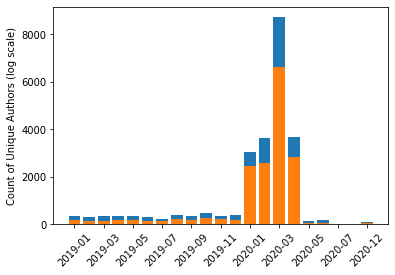

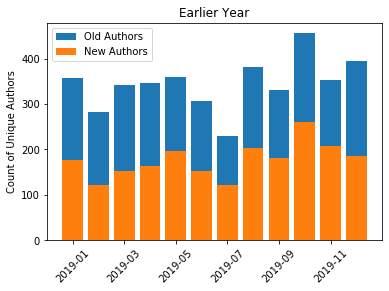

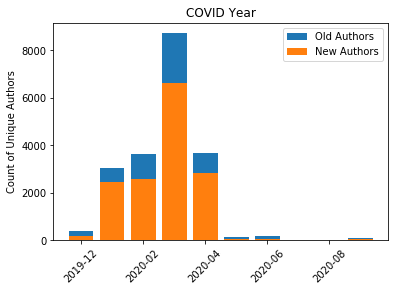

In [91]:
unique_authors_per_month = article_authors[['author_id', 'year_month']].groupby('year_month').nunique()['author_id']
unique_authors_per_month = unique_authors_per_month.reset_index()
new_authors_by_month = pd.DataFrame(earliest_publication[['author_id', 'earliest_month']].\
                 groupby('earliest_month').count()['author_id']).reset_index()
new_authors_by_month


unique_authors_per_month_subset = unique_authors_per_month[unique_authors_per_month['year_month'] >= '2019-01']
new_authors_by_month_subset = new_authors_by_month[new_authors_by_month['earliest_month'] >= '2019-01']
plt.bar(np.arange(len(unique_authors_per_month_subset)), unique_authors_per_month_subset['author_id'])
plt.bar(np.arange(len(new_authors_by_month_subset)), new_authors_by_month_subset['author_id'])
interval = 2
plt.xticks(np.arange(0, len(unique_authors_per_month_subset), interval),
           [a for e, a in enumerate(unique_authors_per_month_subset['year_month']) if e % interval == 0], 
           rotation=45)
# plt.yscale('log')
plt.ylabel('Count of Unique Authors (log scale)')
plt.show()


def plot_stuff(unique_authors_per_month_subset, new_authors_by_month_subset):
    plt.bar(np.arange(len(new_authors_by_month_subset)), unique_authors_per_month_subset['author_id'], label='Old Authors')
    plt.bar(np.arange(len(new_authors_by_month_subset)), new_authors_by_month_subset['author_id'], label='New Authors')
    interval = 2
    plt.xticks(np.arange(0, len(unique_authors_per_month_subset), interval),
               [a for e, a in enumerate(unique_authors_per_month_subset['year_month']) if e % interval == 0], 
               rotation=45)
    # plt.yscale('log')
    plt.ylabel('Count of Unique Authors')
    plt.legend()
    
unique_authors_per_month_subset = unique_authors_per_month[(unique_authors_per_month['year_month'] >= '2019-01') & 
                     (unique_authors_per_month['year_month'] <= '2019-12')]
new_authors_by_month_subset = new_authors_by_month_subset[(new_authors_by_month_subset['earliest_month'] >= '2019-01') & 
                     (new_authors_by_month_subset['earliest_month'] <= '2019-12')]
plot_stuff(unique_authors_per_month_subset, new_authors_by_month_subset)
plt.title('Earlier Year')
plt.show()


unique_authors_per_month_subset = unique_authors_per_month[(unique_authors_per_month['year_month'] >= '2019-12')]
new_authors_by_month_subset = new_authors_by_month[(new_authors_by_month['earliest_month'] >= '2019-12')]
plot_stuff(unique_authors_per_month_subset, new_authors_by_month_subset)
plt.title('COVID Year')
plt.show()

In [92]:
new_authors_by_month = pd.DataFrame(earliest_publication[['author_id', 'earliest_date']].\
                 groupby('earliest_date').nunique()['author_id']).reset_index()
new_authors_by_month_subset = new_authors_by_month[new_authors_by_month['earliest_date'] >= '2019-01-01']
len(new_authors_by_month_subset)

317

Relevant information:
* Authors
* Dates
* 50k authors to check against